# 0. Install and Import dependencies

In [1]:
!pip install tensorflow stable-baselines3[extra] gymnasium

In [1]:
import gymnasium as gym
from gymnasium import spaces

# Stable Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Load BTCUSD and ETHUSD Data 

#### Btc data:
https://www.coingecko.com/it/monete/bitcoin/historical_data?start=2025-01-01&end=2025-05-26
https://www.marketwatch.com/investing/cryptocurrency/btcusd/download-data?mod=mw_quote_ta
#### Eth data:
https://www.coingecko.com/it/monete/ethereum/historical_data?start=2025-01-01&end=2025-05-30
https://www.marketwatch.com/investing/cryptocurrency/ethusd/download-data?startDate=4/28/2021&endDate=4/28/202



In [2]:
# Load DataFrame
df_btc = pd.read_csv('data/BTCUSD_processed.csv')
df_eth = pd.read_csv('data/ETHUSD_processed.csv')

# 2. Build Environment


--- Index 29 ---
open (norm): [6.7129114e-04 9.5898729e-05 1.1979350e-02] ... [0.26025316 0.30725154 0.304926  ]
high (norm): [0.00617748 0.01900393 0.01587124] ... [0.31565067 0.36783555 0.3384346 ]
low (norm): [-0.0073842  -0.01130007  0.00812742] ... [0.24622798 0.3068999  0.30250457]
close (norm): [0.         0.01198734 0.01029313] ... [0.30725154 0.3112553  0.32448933]
sma (norm): [-0.03025472 -0.02705876 -0.02389543] ... [0.28666195 0.28534135 0.28727996]
volume (log+scaled): [0.3170437  0.1723313  0.24476945] ... [0.3497639  0.40935603 0.4949046 ]
rsi (/100): [0.5644521  0.5946402  0.58843255] ... [0.63066906 0.6348125  0.64883614]

Long-Term Features:
  distance_from_sma_200 (scaled): -0.0511
  volatility_100 (scaled): 2.0736
  position_in_200_range (scaled): -0.1745


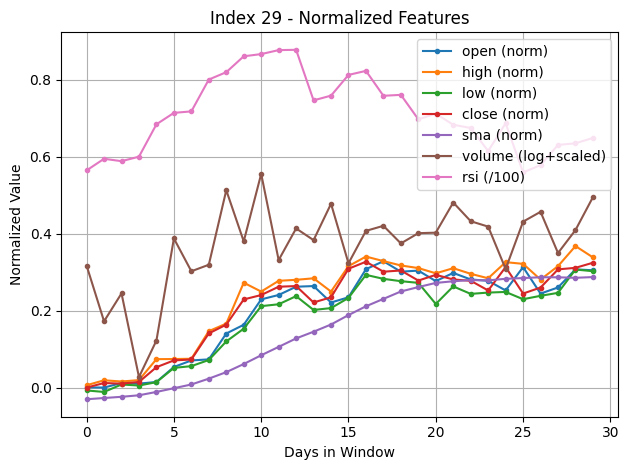


--- Index 79 ---
open (norm): [ 0.02628214  0.         -0.01786661] ... [0.0831883  0.13424288 0.09152895]
high (norm): [0.03838452 0.00495948 0.02903324] ... [0.15935221 0.13649492 0.09978228]
low (norm): [-0.01657527 -0.02704945 -0.01917666] ... [0.07195304 0.07980087 0.07165983]
close (norm): [ 0.         -0.01808495  0.02474126] ... [0.13363153 0.09170987 0.08048709]
sma (norm): [0.02254641 0.02711339 0.03162944] ... [0.07650807 0.08626276 0.08934346]
volume (log+scaled): [0.42149225 0.41886294 0.28991967] ... [0.52261037 0.45694256 0.4726252 ]
rsi (/100): [0.49323907 0.46228507 0.5364698 ] ... [0.62643677 0.56221735 0.5460778 ]

Long-Term Features:
  distance_from_sma_200 (scaled): 0.2562
  volatility_100 (scaled): 0.1759
  position_in_200_range (scaled): 0.8889


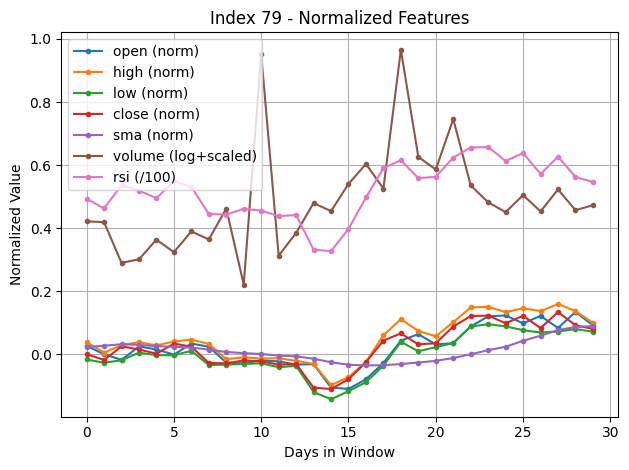


--- Index 129 ---
open (norm): [ 0.00862989 -0.00029676  0.01596267] ... [-0.14031829 -0.14405648 -0.13641259]
high (norm): [0.01134857 0.02324758 0.01980615] ... [-0.13823143 -0.13057317 -0.12702644]
low (norm): [-0.00705995 -0.00634199 -0.01301424] ... [-0.16664831 -0.14405648 -0.14276415]
close (norm): [ 0.          0.01611583 -0.00527941] ... [-0.14405648 -0.1363408  -0.13887759]
sma (norm): [-0.07817399 -0.06844482 -0.06154641] ... [-0.10786287 -0.10807786 -0.11090901]
volume (log+scaled): [0.5964467  0.40867075 0.39629936] ... [0.40697086 0.44499353 0.24077868]
rsi (/100): [0.7406291  0.7575144  0.69301164] ... [0.4146198 0.433081  0.4282984]

Long-Term Features:
  distance_from_sma_200 (scaled): -0.0156
  volatility_100 (scaled): 0.2994
  position_in_200_range (scaled): 0.0667


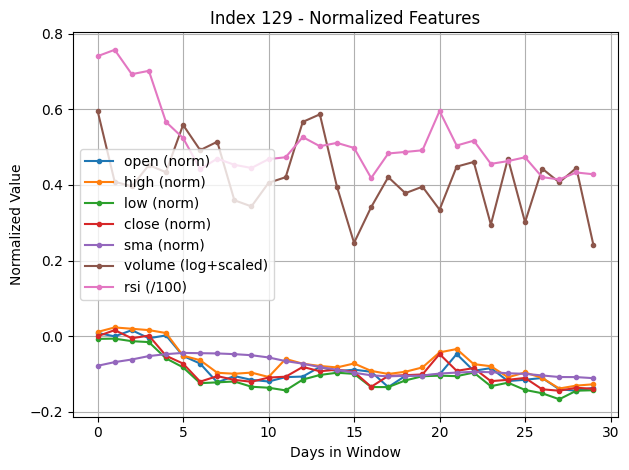

In [3]:
# This function creates a normalized observation vector for the agent at a given timestep
def get_normalized_observation(df_processed, # your full DataFrame (with engineered features)
                               current_idx, # the current timestep index
                               window_size, # how many past days to include in the observation
                               volume_scaler, # scaler fit on log(volume)
                               long_term_feature_scalers): # dictionary of scalers for long-term features
    start_idx = current_idx - window_size + 1 # compute the starting index of the sliding window
    if start_idx < 0:
        raise IndexError("Not enough data for the observation window.")
        
    window_df = df_processed.iloc[start_idx : current_idx + 1] # slice of the df that represents the window of past data

    price_cols = ['open', 'high', 'low', 'close', 'sma'] # price-related features to be normalized
    first_close = window_df['close'].iloc[0]
    
    # Normalize price-like features relative to the first close in the window
    if abs(first_close) < 1e-9: # if it's to close to 0
        price_features = [np.zeros(window_size, dtype=np.float32) for _ in price_cols]
    else: # normalize all prices by dividing by the first close and subtracting 1: makes first value 0 and rest relative
        price_features = [(window_df[col].values / first_close) - 1.0 for col in price_cols]

    # Traded volume of Bitcoin typically has large values and it tends to be very skewed
    # Normalize volume: apply log transform to reduce skew, then scale to [0, 1] for model input
    if 'volume_log' not in window_df.columns:
        window_df = window_df.copy() # changing df from a view to an isolated copy (no link to the original df)
        window_df['volume_log'] = np.log1p(window_df['volume']) # np.log1p(volume) == log(1 + volume)
    normalized_volume = volume_scaler.transform(window_df[['volume_log']]).flatten() # minmax scaling wrt training data

    # Normalize RSI (0–1 scale)
    normalized_rsi = window_df['rsi'].values / 100.0 # RSI is already bounded between 0–100, so dividing by 100 puts it on a 0–1 scale

    # Normalize long-term features from the current day using pre-fit scalers (mean=0, std=1)
    current_features = df_processed.iloc[current_idx]
    normalized_long_term = [
        scaler.transform(pd.DataFrame({name: [current_features[name]]}))[0, 0]
        for name, scaler in long_term_feature_scalers.items()
    ] # The result is a list of normalized long-term feature values, e.g.: normalized_long_term = [0.42, -0.18, 1.25]

    # Combine all into one observation vector
    observation = np.concatenate([
        np.concatenate(price_features),
        normalized_volume,
        normalized_rsi,
        np.array(normalized_long_term)
    ])
    return observation.astype(np.float32)

# Plots and prints values from a single observation vector
def inspect_single_observation(obs_vector, window_size,
                               window_names, # list of labels for windowed features
                               long_term_names, desc="Sample",
                               n=3): # how many values to show from start/end
    total_window_elements = len(window_names) * window_size
    window_part = obs_vector[:total_window_elements] # windowed time-series features
    long_term_part = obs_vector[total_window_elements:] # static daily features

    print(f"\n--- {desc} ---")
    # Loop over each windowed feature, extract its values, print the first/last few (n) values, and plot them
    for i, name in enumerate(window_names):
        vals = window_part[i * window_size : (i + 1) * window_size]
        print(f"{name}: {vals[:n]} ... {vals[-n:]}")
        plt.plot(vals, label=name, marker='.', linestyle='-')

    if long_term_names: # if there are long-term features, print each one’s value
        print("\nLong-Term Features:")
        for name, val in zip(long_term_names, long_term_part):
            print(f"  {name}: {val:.4f}")

    plt.title(f"{desc} - Normalized Features")
    plt.xlabel("Days in Window")
    plt.ylabel("Normalized Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Add volume_log column ---
df_eth['volume_log'] = np.log1p(df_eth['volume'])

# --- Fit scalers on training data only ---
train_split_idx_eth = int(len(df_eth) * 0.7)
train_df_eth = df_eth.iloc[:train_split_idx_eth].copy()

# volume_scaler learns min and max values from the training data only and then uses that to scale future data consistently
volume_scaler = MinMaxScaler().fit(train_df_eth[['volume_log']])

lt_features = ['distance_from_sma_200', 'volatility_100', 'position_in_200_range']
long_term_feature_scalers = {
    feat: StandardScaler().fit(train_df_eth[[feat]]) for feat in lt_features
}

# --- Feature/Plot Labels ---
WINDOW_SIZE = 30
window_names = [
    'open (norm)', 'high (norm)', 'low (norm)', 'close (norm)', 'sma (norm)',
    'volume (log+scaled)', 'rsi (/100)'
]
long_term_names = [f'{f} (scaled)' for f in lt_features]

# --- Inspect a few sample observations ---
# Inspects 3 sample observations from the dataset at increasing intervals (every 50 days),
# to visually verify that features are scaled and encoded correctly
for i in range(min(3, len(df_eth) - WINDOW_SIZE + 1)):
    current_idx = WINDOW_SIZE - 1 + i * 50
    obs = get_normalized_observation(
        df_eth, current_idx, WINDOW_SIZE, volume_scaler, long_term_feature_scalers
    )
    inspect_single_observation(obs, WINDOW_SIZE, window_names, long_term_names, desc=f"Index {current_idx}")


--- Index 29 ---
open (norm): [-0.00322196  0.         -0.00984487] ... [0.16193317 0.24576372 0.24749403]
high (norm): [0.0022673  0.00429594 0.01706444] ... [0.26712412 0.25692123 0.2786396 ]
low (norm): [-0.00542959 -0.01366348 -0.02816229] ... [0.15692124 0.2276253  0.23108593]
close (norm): [ 0.         -0.00984487  0.00608592] ... [0.24576372 0.24749403 0.2699284 ]
sma (norm): [0.02333433 0.02218576 0.02051512] ... [0.05792065 0.07905231 0.10133751]
volume (log+scaled): [0.6281254  0.5753871  0.65605545] ... [0.79528457 0.8343944  0.70187837]
rsi (/100): [0.4394132  0.41757977 0.463992  ] ... [0.90512174 0.9057841  0.9141514 ]

Long-Term Features:
  distance_from_sma_200 (scaled): -0.4912
  volatility_100 (scaled): 0.7263
  position_in_200_range (scaled): -0.4851


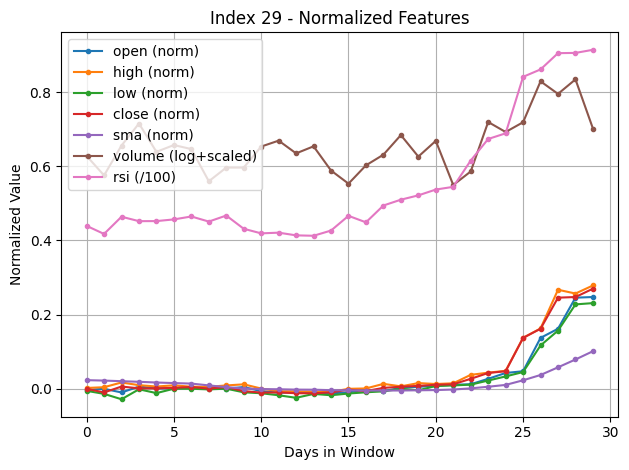


--- Index 79 ---
open (norm): [-0.00517211  0.          0.00873609] ... [-0.03298853 -0.02590403 -0.02855529]
high (norm): [0.00604138 0.01447323 0.01855876] ... [-0.01586405 -0.01808067 -0.01994958]
low (norm): [-0.01577712 -0.01573366 -0.01425591] ... [-0.03637865 -0.03142385 -0.04624479]
close (norm): [ 0.          0.00873609 -0.00730181] ... [-0.02590403 -0.02855529 -0.04133345]
sma (norm): [0.00970677 0.01003999 0.00905482] ... [ 0.00678749  0.00157192 -0.00524455]
volume (log+scaled): [0.7270926  0.76900524 0.7923433 ] ... [0.60744864 0.6391996  0.6865713 ]
rsi (/100): [0.60667515 0.6221558  0.5772391 ] ... [0.4338226  0.42845315 0.40258995]

Long-Term Features:
  distance_from_sma_200 (scaled): -0.3470
  volatility_100 (scaled): -0.9918
  position_in_200_range (scaled): -0.2377


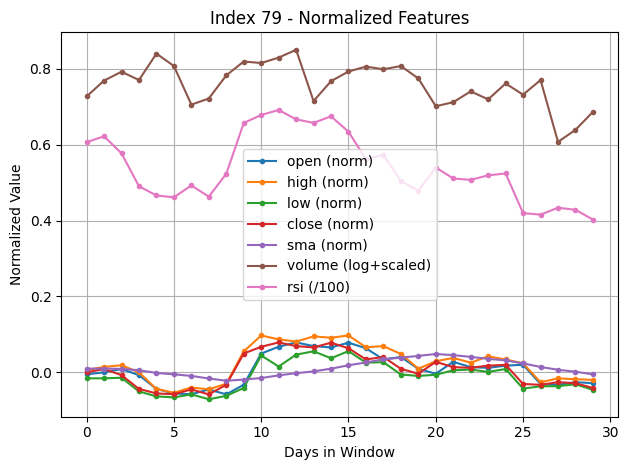


--- Index 129 ---
open (norm): [-1.6769961e-02  7.2912866e-05  3.5909589e-02] ... [ 0.00174991 -0.00178637  0.00699964]
high (norm): [0.00262486 0.04385709 0.06354357] ... [0.02048852 0.01206708 0.09398469]
low (norm): [-0.02774335 -0.01086402  0.01093693] ... [-0.01567627 -0.00816624  0.00699964]
close (norm): [0.         0.03561794 0.02016041] ... [-0.00182282  0.00703609  0.01753554]
sma (norm): [0.00622494 0.01084579 0.01254101] ... [0.05793231 0.04960809 0.04220744]
volume (log+scaled): [0.66371566 0.6554551  0.6863466 ] ... [0.58002704 0.6430751  0.6494876 ]
rsi (/100): [0.5896048  0.62647027 0.6012289 ] ... [0.4308591  0.45152834 0.4758253 ]

Long-Term Features:
  distance_from_sma_200 (scaled): 0.5332
  volatility_100 (scaled): 1.1762
  position_in_200_range (scaled): 0.3657


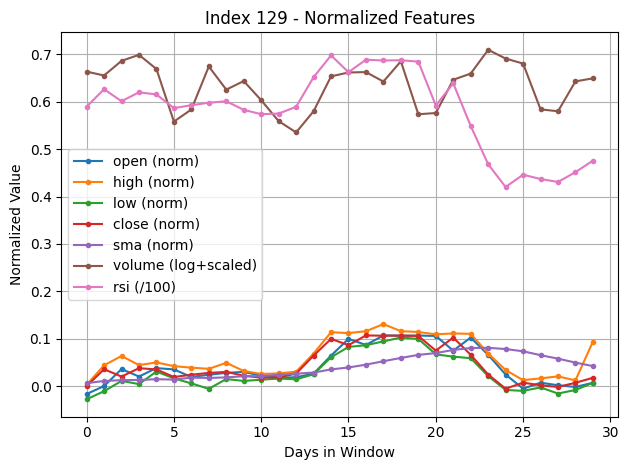

In [4]:
# --- Add volume_log column ---
df_btc['volume_log'] = np.log1p(df_btc['volume'])

# --- Fit scalers on training data only ---
train_split_idx_btc = int(len(df_btc) * 0.8)
train_df_btc = df_btc.iloc[:train_split_idx_btc].copy()

# volume_scaler learns min and max values from the training data only and then uses that to scale future data consistently
volume_scaler = MinMaxScaler().fit(train_df_btc[['volume_log']])

lt_features = ['distance_from_sma_200', 'volatility_100', 'position_in_200_range']
long_term_feature_scalers = {
    feat: StandardScaler().fit(train_df_btc[[feat]]) for feat in lt_features
}

# --- Feature/Plot Labels ---
WINDOW_SIZE = 30
window_names = [
    'open (norm)', 'high (norm)', 'low (norm)', 'close (norm)', 'sma (norm)',
    'volume (log+scaled)', 'rsi (/100)'
]
long_term_names = [f'{f} (scaled)' for f in lt_features]

# --- Inspect a few sample observations ---
# Inspects 3 sample observations from the dataset at increasing intervals (every 50 days),
# to visually verify that features are scaled and encoded correctly
for i in range(min(3, len(df_btc) - WINDOW_SIZE + 1)):
    current_idx = WINDOW_SIZE - 1 + i * 50
    obs = get_normalized_observation(
        df_btc, current_idx, WINDOW_SIZE, volume_scaler, long_term_feature_scalers
    )
    inspect_single_observation(obs, WINDOW_SIZE, window_names, long_term_names, desc=f"Index {current_idx}")

## 2.2 Create New Environments

In [5]:
class BitcoinTradingEnv(gym.Env): # OpenAI Gym enviroment
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    # Constructor
    def __init__(self,
                 df, # dataframe with historical data (price, volume, etc.)
                 window_size, # how many days of historical data to use in the observation
                 initial_balance, # starting USD amount
                 volume_scaler, long_term_feature_scalers, # normalization tools
                 transaction_cost_pct=0.0):  # transaction fee (not used here)
        
        super().__init__() # initializes the parent gym.Env class

        # Store inputs as instance variables
        self.df = df
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.volume_scaler = volume_scaler
        self.long_term_feature_scalers = long_term_feature_scalers
        self.transaction_cost_pct = transaction_cost_pct

        # Parameters for the environment logic
        self.holding_penalty_pct = 0.001 # penalty for holding during volatility
        self.action_reward = 0.1  # bonus for any trade

        # Define action and observation spaces
        self.action_space = spaces.Discrete(2) # buy, sell
        self.obs_vector_length = (5 * window_size) + window_size + window_size + len(long_term_feature_scalers)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.obs_vector_length,), dtype=np.float32
        ) # an array (1D vector of floats with no bounds) containing the 30 days window with all 7 features + the 2 long term features

        # Initialize the environment state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size - 1 # start after window_size to ensure a full historical window is available
        self.balance = self.initial_balance # starting with initial_balance USD
        self.btc_held = 0.0 # starting with 0 BTC
        self.net_worth = self.initial_balance
        self.max_steps = len(self.df) - 1 # agent goes through all the dataset (training or testing)
        self.prev_price = self._get_current_price()
        self.buy_price = None
        self.short_price = None  # price at which short was initiated
        self.btc_shorted = 0.0   # how much BTC was shorted
        self.current_position = 0  # 1 for long, -1 for short, 0 for neutral
        return self._get_observation(), self._get_info()

    def _get_current_price(self): # returns the current closing price
        return self.df['close'].iloc[self.current_step]

    # Builds the state from historical and long-term features
    def _get_observation(self):
        return get_normalized_observation( # call the function to get and normalize the previous 30 days
            self.df, self.current_step, self.window_size,
            self.volume_scaler, self.long_term_feature_scalers
        )

    # Returns details about the environment’s current state for logging/debugging
    def _get_info(self):
        return {
            "step": self.current_step,
            "balance": self.balance,
            "btc_held": self.btc_held,
            "net_worth": self.net_worth,
            "current_price": self._get_current_price(),
            "btc_shorted": self.btc_shorted,
            "short_price": self.short_price,
            "current_position": self.current_position
        }

    # Executes one step in the environment based on the action taken
    def step(self, action):
        prev_net_worth = self.net_worth
        current_price = self._get_current_price()
        reward = 0.0

        # Penalty for holding in volatile conditions (missing opportunities or not avoiding losses)
        price_change = abs(current_price - self.prev_price) / self.prev_price if self.prev_price > 0 else 0 # relative price change
        high_volatility = price_change > 0.001 # volatile market if the price changed 0,5% w.r.t. the previous day

        # --- ACTION EXECUTION ---
        # Buy: opens a long position if holding cash or closes a short
        # Sell: opens a short if not holding BTC or closes a long
        # Hold: does nothing
        # Now we allow short-selling: you can sell BTC even if you don't own it (go short)
        
        # Buy
        if action == 0:
            # If currently shorting, close short position
            if self.btc_shorted > 0:
                cost_to_cover = self.btc_shorted * current_price # buying the "borrowed" btc at current price
                short_profit = (self.short_price - current_price) * self.btc_shorted  # profit if price dropped
                self.balance -= cost_to_cover
                self.balance += self.short_price * self.btc_shorted  # add back what we "sold" at start of the short position

                # Calculating the profit relative to the dimension of the short position
                profit_pct = short_profit / (self.short_price * self.btc_shorted) if self.short_price > 0 else 0
                reward += profit_pct * 100 # amplify profit or loss reward
                reward += self.action_reward
        
                self.btc_shorted = 0.0
                self.short_price = None
                self.current_position = 0  # closed short
        
            # Otherwise, go long if not already holding BTC
            elif self.balance > 0:
                amount = self.balance
                btc_bought = amount / current_price if current_price > 0 else 0
                self.btc_held += btc_bought
                self.balance = 0
                self.buy_price = current_price # stores buy_price for profit calculation on sell
                reward += self.action_reward # adds a small reward for making a trade
                self.current_position = 1 # opening a long

            elif high_volatility: # applies a small penalty for holding BTC during volatile price changes
                reward -= self.holding_penalty_pct * self.initial_balance
        
        # Sell
        elif action == 1:
            # If holding BTC, sell and close long position
            if self.btc_held > 0: # Sells all the BTC at the current price
                sell_value = self.btc_held * current_price
                self.balance += sell_value
                self.btc_held = 0
        
                if self.buy_price: # if buy_price is set, calculates profit % and add reward
                    profit_pct = (current_price - self.buy_price) / self.buy_price
                    reward += profit_pct * 100 # amplify profit or loss reward
                reward += self.action_reward # adding the small reward for taking an action (a trade)
                self.buy_price = None # because the trade (long) is concluded
                self.current_position = 0 # close long
        
            # Otherwise, open short position if not already shorting
            elif self.btc_shorted == 0:
                # short entire balance worth of BTC
                btc_shorted = (self.balance / 2) / current_price if current_price > 0 else 0 # shorting half of the balance
                self.btc_shorted = btc_shorted
                self.short_price = current_price
                reward += self.action_reward # adding the small reward for opening a position
                self.current_position = -1 # go short

            elif high_volatility:   # penalize holding short during volatile price changes
                reward -= self.holding_penalty_pct * self.initial_balance

        # Update net worth
        short_liability = self.btc_shorted * current_price # if shorting, we assume borrowed BTC must be bought back later (liability)
        self.net_worth = self.balance + self.btc_held * current_price - short_liability

        # Give a reward for an every step feedback and to encourage the agent to exit losing positions
        # reward += (self.net_worth - prev_net_worth) * 0.01  # small net worth delta
        reward += (self.net_worth - prev_net_worth) / self.initial_balance * 100  # = % gain
        # So every step gives a small reward: e.g. +0.5 for 0.5% net worth increase or -1.0 for 1% drop

        self.prev_price = current_price
        self.current_step += 1 # move to the next time step

        # Ends episode if: reached end of dataset or the net worth falls below 10% of initial balance
        terminated = self.current_step >= self.max_steps or self.net_worth <= self.initial_balance * 0.1
        truncated = False

        # In Gym environments, the step() function must always return an observation, even if the episode has ended 
        observation = (
            self._get_observation() if not terminated
            else np.zeros(self.observation_space.shape, dtype=np.float32) # if episode is over, return a dummy observation
        )

        if terminated:
            info = self._get_info()
            info["episode"] = {
                "r": float(self.net_worth - self.initial_balance),  # or sum of rewards if you track them
                "l": self.current_step
            }
        else:
            info = self._get_info()

        return observation, reward, terminated, truncated, self._get_info()

    # Print summary of the current portfolio status
    def render(self):
        print(f"Step: {self.current_step} | Net Worth: ${self.net_worth:.2f} | BTC Held: {self.btc_held:.6f} | Shorted: {self.btc_shorted:.6f} | Balance: ${self.balance:.2f}")

# 3. Training

In [6]:
# Parameters
WINDOW_SIZE = 30
INITIAL_BALANCE = 10000
TRANSACTION_COST = 0 #0.001  # example value

# Split dataset (train_ratio = 0.8) -> split_idx = int(len(df_processed) * train_ratio)
# I want the same period for testing: from 08/11/2024 until 30/04/2025
# btc: 692 (866 (-1)) I want the last 173 rows
split_idx_btc = 692
# eth: 848-173 = 675
split_idx_eth = 675

df_test_btc = df_btc.iloc[split_idx_btc:].reset_index(drop=True)
df_test_eth = df_eth.iloc[split_idx_eth:].reset_index(drop=True)

# Arguments for the environment constructor
# BTC
test_env_args_btc = dict(
    df=df_test_btc,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

# ETH
test_env_args_eth = dict(
    df=df_test_eth,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

def make_test_env_btc():
    return BitcoinTradingEnv(**test_env_args_btc)

def make_test_env_eth():
    return BitcoinTradingEnv(**test_env_args_eth)

# Vectorized Envs
test_vec_env_btc = DummyVecEnv([make_test_env_btc])
test_vec_env_eth = DummyVecEnv([make_test_env_eth])

# 4. Testing

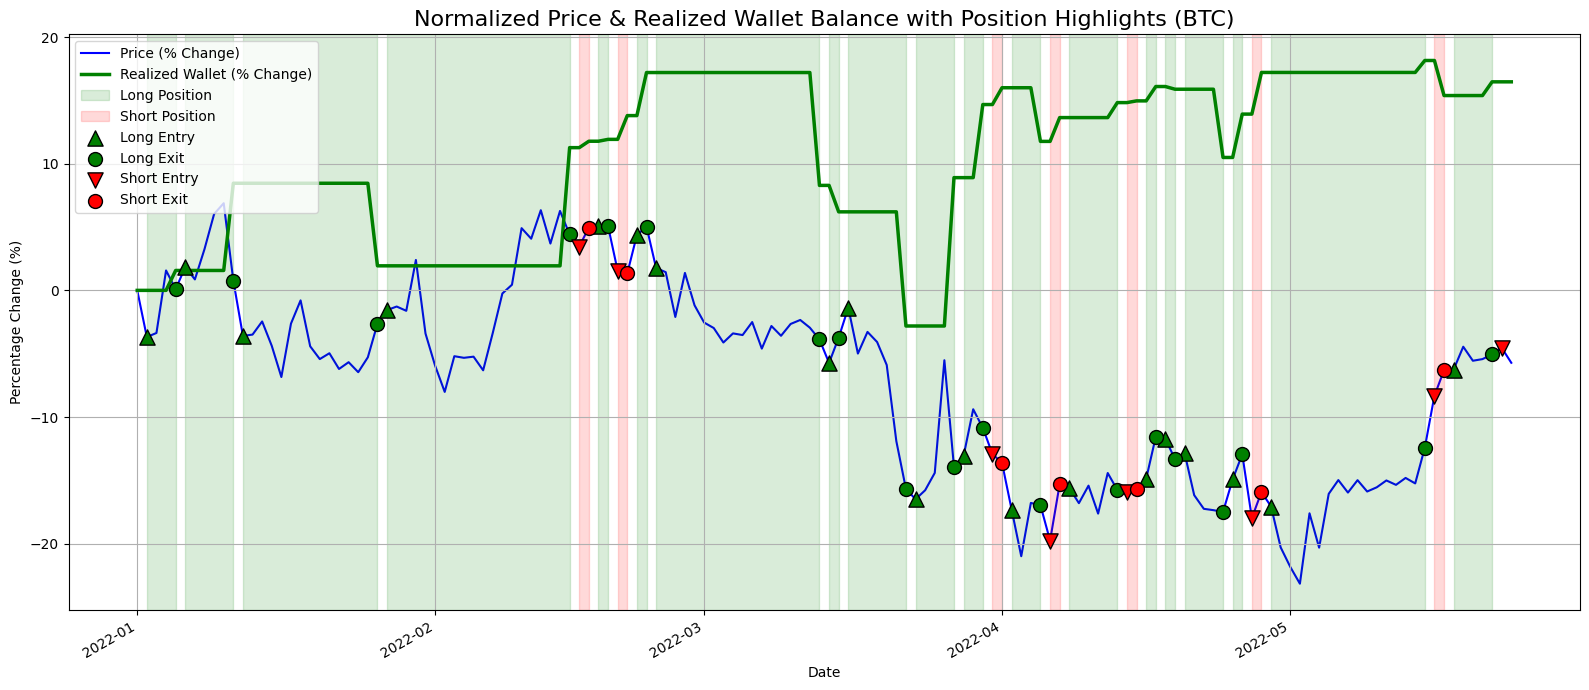

In [16]:
# Load the trained model
model = PPO.load("ppo_bitcoin_trader_3M_short", env=test_vec_env_btc)

# Create a fresh test environment
test_env_btc = BitcoinTradingEnv(**test_env_args_btc)

obs, info = test_env_btc.reset()
done = False

net_worths = [info["net_worth"]]
prices = [info["current_price"]]
actions = []
positions = [info["current_position"]]

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)
    obs, reward, terminated, truncated, info = test_env_btc.step(action)
    done = terminated or truncated

    net_worths.append(info["net_worth"])
    prices.append(info["current_price"])
    actions.append(action)
    positions.append(info["current_position"])

actions = [None] + actions  # Align with net_worths/prices

# Normalize price and net worth
price_pct = 100 * (np.array(prices) / prices[0] - 1)
net_worths = np.array(net_worths)

# Rebuild position state tracking
positions = []
current_position = 0
for action in actions:
    if action == 0:  # Buy
        if current_position == -1:
            current_position = 0
        elif current_position == 0:
            current_position = 1
    elif action == 1:  # Sell
        if current_position == 1:
            current_position = 0
        elif current_position == 0:
            current_position = -1
    positions.append(current_position)

# Identify entry/exit points
long_entry_idx, long_exit_idx = [], []
short_entry_idx, short_exit_idx = [], []

for i in range(1, len(positions)):
    prev, curr = positions[i-1], positions[i]
    if prev == 0 and curr == 1:
        long_entry_idx.append(i)
    elif prev == 1 and (curr == 0 or curr == -1):
        long_exit_idx.append(i)
    elif prev == 0 and curr == -1:
        short_entry_idx.append(i)
    elif prev == -1 and (curr == 0 or curr == 1):
        short_exit_idx.append(i)

# Build realized wallet balance
realized_net_worth = [net_worths[0]]
last_realized_value = net_worths[0]
prev_position = positions[0]

for i in range(1, len(positions)):
    curr_position = positions[i]
    if prev_position != 0 and (curr_position == 0 or np.sign(curr_position) != np.sign(prev_position)):
        last_realized_value = net_worths[i]
    realized_net_worth.append(last_realized_value)
    prev_position = curr_position

wallet_pct = 100 * (np.array(realized_net_worth) / realized_net_worth[0] - 1)

# Create a fake date range for plotting
dates = pd.date_range(start='2022-01-01', periods=len(prices), freq='D')

# Plotting
fig, ax = plt.subplots(figsize=(16, 7))

# Plot normalized price and wallet
ax.plot(dates, price_pct, label='Price (% Change)', color='blue', zorder=1)
ax.plot(dates, wallet_pct, label='Realized Wallet (% Change)', color='green', linewidth=2.5)

# Highlight position holding periods
def shade_positions(entry_indices, color, label):
    for idx in entry_indices:
        for end in range(idx + 1, len(positions)):
            if positions[end] != positions[idx]:
                ax.axvspan(dates[idx], dates[end], color=color, alpha=0.15, label=label if idx == entry_indices[0] else "")
                break

shade_positions(long_entry_idx, 'green', 'Long Position')
shade_positions(short_entry_idx, 'red', 'Short Position')

# Entry/exit markers
ax.scatter(np.array(dates)[long_entry_idx], price_pct[long_entry_idx],
           marker='^', color='green', s=120, edgecolor='black', label='Long Entry', zorder=3)
ax.scatter(np.array(dates)[long_exit_idx], price_pct[long_exit_idx],
           marker='o', color='green', s=100, edgecolor='black', label='Long Exit', zorder=3)

ax.scatter(np.array(dates)[short_entry_idx], price_pct[short_entry_idx],
           marker='v', color='red', s=120, edgecolor='black', label='Short Entry', zorder=3)
ax.scatter(np.array(dates)[short_exit_idx], price_pct[short_exit_idx],
           marker='o', color='red', s=100, edgecolor='black', label='Short Exit', zorder=3)

# Formatting
ax.set_title('Normalized Price & Realized Wallet Balance with Position Highlights (BTC)', fontsize=16)
ax.set_ylabel('Percentage Change (%)')
ax.set_xlabel('Date')
ax.grid(True)
ax.legend(loc='upper left')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

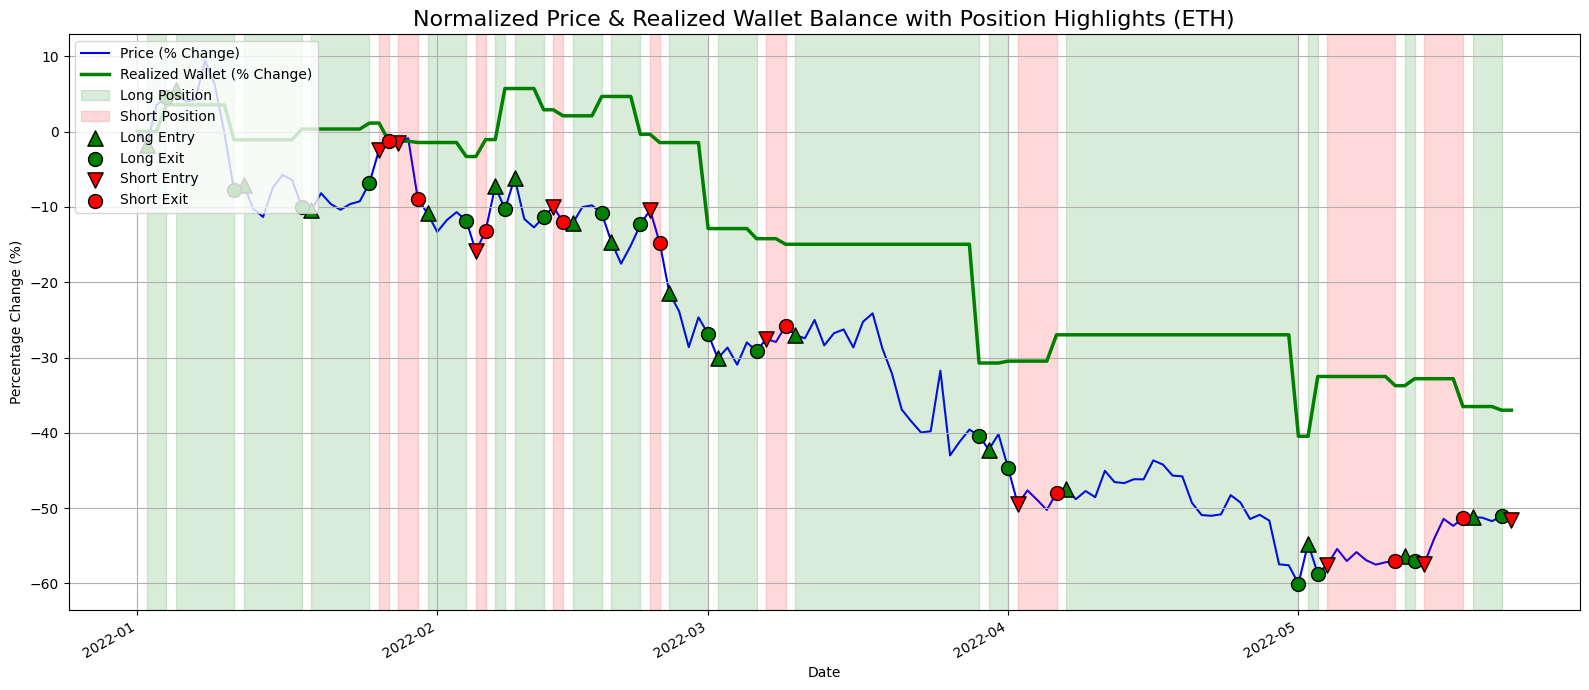

In [14]:
# Load the trained model
model = PPO.load("ppo_bitcoin_trader_3M_short", env=test_vec_env_eth)

# Create a fresh test environment instance
test_env_eth = BitcoinTradingEnv(**test_env_args_eth)

# Initialize environment
obs, info = test_env_eth.reset()
done = False

net_worths = [info["net_worth"]]
prices = [info["current_price"]]
actions = []
positions = [info["current_position"]]

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)
    obs, reward, terminated, truncated, info = test_env_eth.step(action)
    done = terminated or truncated
    
    net_worths.append(info["net_worth"])
    prices.append(info["current_price"])
    actions.append(action)
    positions.append(info["current_position"])

actions = [None] + actions  # Align with net_worths/prices

# Normalize price and net worth
price_pct = 100 * (np.array(prices) / prices[0] - 1)
net_worths = np.array(net_worths)

# Rebuild position state tracking from actions
positions = []
current_position = 0
for action in actions:
    if action == 0:  # Buy
        if current_position == -1:
            current_position = 0
        elif current_position == 0:
            current_position = 1
    elif action == 1:  # Sell
        if current_position == 1:
            current_position = 0
        elif current_position == 0:
            current_position = -1
    positions.append(current_position)

# Identify entry/exit points
long_entry_idx, long_exit_idx = [], []
short_entry_idx, short_exit_idx = [], []

for i in range(1, len(positions)):
    prev, curr = positions[i-1], positions[i]
    if prev == 0 and curr == 1:
        long_entry_idx.append(i)
    elif prev == 1 and (curr == 0 or curr == -1):
        long_exit_idx.append(i)
    elif prev == 0 and curr == -1:
        short_entry_idx.append(i)
    elif prev == -1 and (curr == 0 or curr == 1):
        short_exit_idx.append(i)

# Build realized wallet balance (only changes on position close)
realized_net_worth = [net_worths[0]]
last_realized_value = net_worths[0]
prev_position = positions[0]

for i in range(1, len(positions)):
    curr_position = positions[i]
    if prev_position != 0 and (curr_position == 0 or np.sign(curr_position) != np.sign(prev_position)):
        last_realized_value = net_worths[i]
    realized_net_worth.append(last_realized_value)
    prev_position = curr_position

wallet_pct = 100 * (np.array(realized_net_worth) / realized_net_worth[0] - 1)

# Create date range for plotting
dates = pd.date_range(start='2022-01-01', periods=len(prices), freq='D')

# Plotting
fig, ax = plt.subplots(figsize=(16, 7))

# Plot normalized price and wallet
ax.plot(dates, price_pct, label='Price (% Change)', color='blue', zorder=1)
ax.plot(dates, wallet_pct, label='Realized Wallet (% Change)', color='green', linewidth=2.5)

# Highlight position holding periods
def shade_positions(entry_indices, color, label):
    for idx in entry_indices:
        for end in range(idx + 1, len(positions)):
            if positions[end] != positions[idx]:
                ax.axvspan(dates[idx], dates[end], color=color, alpha=0.15, label=label if idx == entry_indices[0] else "")
                break

shade_positions(long_entry_idx, 'green', 'Long Position')
shade_positions(short_entry_idx, 'red', 'Short Position')

# Entry/exit markers
ax.scatter(np.array(dates)[long_entry_idx], price_pct[long_entry_idx],
           marker='^', color='green', s=120, edgecolor='black', label='Long Entry', zorder=3)
ax.scatter(np.array(dates)[long_exit_idx], price_pct[long_exit_idx],
           marker='o', color='green', s=100, edgecolor='black', label='Long Exit', zorder=3)

ax.scatter(np.array(dates)[short_entry_idx], price_pct[short_entry_idx],
           marker='v', color='red', s=120, edgecolor='black', label='Short Entry', zorder=3)
ax.scatter(np.array(dates)[short_exit_idx], price_pct[short_exit_idx],
           marker='o', color='red', s=100, edgecolor='black', label='Short Exit', zorder=3)

# Formatting
ax.set_title('Normalized Price & Realized Wallet Balance with Position Highlights (ETH)', fontsize=16)
ax.set_ylabel('Percentage Change (%)')
ax.set_xlabel('Date')
ax.grid(True)
ax.legend(loc='upper left')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()